In [1]:
from sys import path
path.append("/home/ec2-user/SageMaker/data-science-development/utils")
path.append("/home/ec2-user/SageMaker/data-science-development/config")

import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

import os
import torch
import random
import json
import datetime
import time

from torch import nn
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

from datetime import datetime
from collections import defaultdict, Counter
from tqdm import tqdm 
from heapq import nlargest

tqdm.pandas()

In [2]:
skills = pd.read_csv("../Data/skills_one-hot.csv").set_index("candidate_id")
skills.head()

,skill_1,skill_2,skill_3,skill_5,skill_6,skill_7,skill_8,skill_9,skill_12,skill_13,...,skill_3926,skill_3927,skill_3928,skill_3929,skill_3930,skill_3931,skill_3932,skill_3933,skill_3934,skill_3935
candidate_id,,,,,,,,,,,,,,,,,,,,,
84267,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84349,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84381,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84386,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84432,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
skills = dict(zip(skills.index, skills.values))

In [4]:
certs = pd.read_csv("../Data/candidate_certificates_one-hot.csv").set_index("candidate_id")
certs.head()

,1,10,11,12,13,14,15,16,17,18,...,W4,W5,W7,W9,WB,WC,WD,WE,WF,ZW
candidate_id,,,,,,,,,,,,,,,,,,,,,
84603,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84867,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
85035,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
85102,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
85214,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
certs = dict(zip(certs.index, certs.values))

In [6]:
licenses = pd.read_csv("../Data/licenses_one-hot.csv").set_index("candidate_id")
licenses.head()

,A,B,BE,C,CE,D,DE,G
candidate_id,,,,,,,,
84556,0,1,0,0,0,0,0,0
84612,0,0,0,0,0,0,0,1
84731,1,1,0,0,0,0,0,0
85437,0,1,0,0,0,0,0,0
85627,0,1,1,0,0,0,0,0


In [7]:
licenses = dict(zip(licenses.index, licenses.values))

In [8]:
languages = pd.read_csv("../Data/languages_one-hot.csv").set_index("candidate_id")
languages.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
candidate_id,,,,,,,,,,,,,,,,,,,,,
84267,0,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84349,0,0,1,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84381,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
84386,0,0,1,1,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
84432,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
languages = dict(zip(languages.index, languages.values))

In [10]:
addresses = pd.read_csv("../Data/addresses_one-hot.csv").set_index("candidate_id")
addresses.head()

,0
candidate_id,
84556,91
84612,49
84731,3773
85437,3819
85627,1560


In [11]:
addresses = dict(zip(addresses.index, addresses.values))

In [12]:
w2v = json.load(open("../Data/embeddings.json"))
# Convert to ints
w2v = {int(k):{int(k2):v2 for k2, v2 in v.items()} for k, v in w2v.items()}

In [13]:
df_pred = pd.read_csv("../Data/df_pred_ext.csv").drop("Unnamed: 0", axis=1)

In [14]:
df_pred = df_pred.drop(["time_between", "job_order", "source"], axis=1)

In [15]:
# df_pred["time_between"] = (df_pred["time_between"] - df_pred["time_between"].mean()) / df_pred["time_between"].std()
df_pred["time_spent"] = (df_pred["time_spent"] - df_pred["time_spent"].mean()) / df_pred["time_spent"].std()

In [16]:
df_pred.head()

,candidate_id,time_spent,isco_functie_niveau,education,company_name,function_id,isco_code4
0,84556,-0.210459,2.0,0.0,324258,936,208
1,84556,-0.252626,1.0,0.0,324258,809,348
2,84556,-0.085012,2.0,0.0,329244,936,208
3,84556,-0.370694,1.0,0.0,368140,1519,344
4,84556,-0.363314,1.0,0.0,419826,1519,344


In [17]:
majority_class = df_pred["isco_code4"].mode().values[0]

<AxesSubplot:>

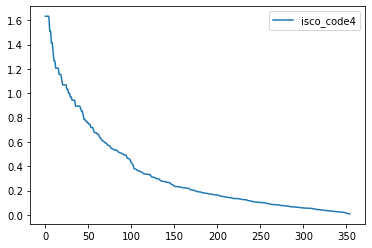

In [18]:
(2 / (0.5 * np.sqrt(df_pred["isco_code4"].value_counts().sort_values().reset_index().drop("index", axis=1)))).plot()

In [19]:
career_paths = df_pred.groupby("candidate_id")

In [20]:
candidate_lens = career_paths.apply(lambda x: len(x) - 1).to_dict()

In [21]:
num_classes = len(df_pred["isco_code4"].unique())
num_features = len(career_paths.mean().columns)
num_classes, num_features

(355, 6)

In [22]:
maximum_career_duration = 25

In [23]:
# Convert to 2d-arrays, grabbing the last 25 jobs of each candidate and getting rid of candidate_ids as values
career_paths = career_paths.progress_apply(lambda x: x.values[-(maximum_career_duration + 1):,1:])

100%|██████████| 469568/469568 [00:52<00:00, 8957.42it/s]


In [24]:
# Drop careers that are only 1 job long
career_lens = career_paths.apply(len)
career_paths = career_paths.loc[(career_lens > 1)]

In [25]:
career_paths = career_paths.loc[career_paths.apply(lambda x: x[-1][-1] != x[-2][-1])]

In [26]:
career_paths.head()

candidate_id
84556    [[-0.21045870102048395, 2.0, 0.0, 324258.0, 93...
84612    [[-0.3685852264755267, 1.0, 0.0, 201740.0, 151...
84731    [[-0.35066422025728855, 1.0, 0.0, 353745.0, 15...
85437    [[0.3313881928721292, 1.0, 2.0, 5500.0, 1519.0...
85888    [[-0.2895219637480053, 2.0, 3.0, 423330.0, 795...
dtype: object

In [27]:
idxs = []
x = []
y = []

# max_skills = len([col for col in df_pred if "skill_" in col])

for idx, career in zip(career_paths.index, career_paths.values):
    label = career[-1, -1]
    
    if not np.isnan(label):       
        idxs.append(idx)
        x.append(career[:-1].reshape(len(career) - 1, num_features))
        y.append(label)

idxs = np.array(idxs)
x = np.array(x)
y = np.array(y)

In [28]:
to_fill = np.zeros([len(x), len(max(x, key = lambda x: len(x))), num_features])

for i,j in enumerate(x):
    if len(j):
        to_fill[i][-len(j):] = j

In [29]:
max_len = len(max(x, key = lambda x: len(x)))
max_len

25

In [30]:
del df_pred
del x

In [31]:
device = ("cuda:0" if torch.cuda.is_available() else "cpu")
device

'cuda:0'

In [32]:
# Filtered: (113428, 113428)
# Grouped: (176485, 176485)
len(to_fill), len(y)

(113724, 113724)

In [33]:
# to_fill = to_fill[:50000]
# y = y[:50000]

In [34]:
def create_loaders(to_fill, idxs, y, split_size=0.8, weight_type=3, batch_size=512):

    # Train test split
    split = split_size

    training = np.array(random.sample(range(len(to_fill)), int(split * len(to_fill))))
    test = np.array(list(set(range(len(to_fill))) - set(training)))

    train_indices, val_indices = idxs[training], idxs[test]
    X_train, X_val = to_fill[training], to_fill[test]
    y_train, y_val = y[training].astype(int), y[test].astype(int)

    # Class weights
    counts = (np.bincount(y_train) + 1)
    
    if weight_type == 1:
        labels_weights = 1. / counts
    elif weight_type == 2:
        labels_weights = 1. / np.sqrt(counts)
    elif weight_type == 3:
        labels_weights = 2. / (0.5 * np.sqrt(counts))
    else:
        return NotImplemented
        
    weights = labels_weights[y_train]
    sampler = WeightedRandomSampler(weights, len(weights))

    # Create dataloaders
    train_data = TensorDataset(torch.Tensor(train_indices), 
                               torch.Tensor(X_train), 
                               torch.Tensor(y_train).type(torch.LongTensor))

    trainloader = DataLoader(train_data, batch_size=batch_size, sampler=sampler)

    val_data = TensorDataset(torch.Tensor(val_indices),
                             torch.Tensor(X_val),
                             torch.Tensor(y_val).type(torch.LongTensor))

    valloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
    
    return trainloader, valloader

In [35]:
class attention(nn.Module):
    
    def __init__(self, hidden_size):
        super(attention, self).__init__()

        # Attention layer
        self.att_fc = nn.Linear(hidden_size, 1)
    
    def forward(self, outputs):
        
        # Deal with batches 
        outputs = outputs.transpose(0, 1)
        att_weight = []
        
        # Determine weight of each timestep
        for timestep in outputs:
            x = self.att_fc(timestep)
            x = torch.tanh(x)
            att_weight.append(x)
                        
        # Normalize            
        normalized_weights = nn.functional.softmax(torch.cat(att_weight, 1), 1)
        
        # Transpose to match normalized_weights
        outputs = outputs.transpose(0, 1)
        outputs = outputs.transpose(1, 2)
        
        # Multiply each timestep by its weight
        attn_applied = outputs * normalized_weights.unsqueeze(1)
        
        # Weighted sum over time steps
        attn_applied = attn_applied.sum(dim=2)
        
        return attn_applied, normalized_weights

In [37]:
class HCPNN(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, 
                 num_layers, skills, certs, licenses, languages, 
                 addresses, w2v, candidate_lengths, max_len, dropout_prob=0.3,
                 skill_embedding_size=50, certs_embedding_size=20,
                 license_embedding_size=3, language_embedding_size=10,
                 address_embedding_size=25, function_embedding_size=50, 
                 isco4_embedding_size=25, education_embedding_size=3, 
                 isco_level_embedding_size=3, company_embedding_size=50):
        
        super(HCPNN, self).__init__()
              
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size + 300
        self.hidden_size = hidden_size
        
        # Static embeddings: skills, certificates, licenses, languages
        self.skill_embedding = nn.Linear(317, skill_embedding_size, bias=False)
        self.skill_embedding.weight.data = torch.randn_like(self.skill_embedding.weight) 
        
        self.certs_embedding = nn.Linear(98, certs_embedding_size, bias=False)
        self.certs_embedding.weight.data = torch.randn_like(self.certs_embedding.weight) 
        
        self.license_embedding = nn.Linear(8, license_embedding_size, bias=False)
        self.license_embedding.weight.data = torch.randn_like(self.license_embedding.weight) 
        
        self.language_embedding = nn.Linear(23, language_embedding_size, bias=False)
        self.language_embedding.weight.data = torch.randn_like(self.language_embedding.weight) 
        
        # Address embedding
        self.address_embedding = nn.Embedding(4768, address_embedding_size)       
        
        # Categorical feature embeddings isco_functie_niveau	source	education	company_name	function_id	isco_code4
        self.function_embedding = nn.Embedding(2993, function_embedding_size)
        self.isco_code_embedding = nn.Embedding(num_classes, isco4_embedding_size)
        self.company_embedding = nn.Embedding(441153, company_embedding_size)
        self.source_embedding = nn.Embedding(2, 1)
        self.education_embedding = nn.Embedding(6, education_embedding_size)
        self.isco_level_embedding = nn.Embedding(5, isco_level_embedding_size)
        
        self.LSTMs = nn.ModuleList()
        
        for i in range(num_layers):
            # input size + embedding
            input_size = self.input_size + (function_embedding_size + isco4_embedding_size + company_embedding_size + 1 +
                                            education_embedding_size + isco_level_embedding_size - 6) if i == 0 else hidden_size
                                                  
            self.LSTMs.append(nn.LSTM(input_size=input_size,
                                      hidden_size=hidden_size,
                                      num_layers=1,
                                      batch_first=True))
            
        self.attention = attention(hidden_size)
        
        self.dropout = nn.Dropout(p=dropout_prob)
        
        # Final fully-connected layer takes the LSTM output, as well as the static embeddings
        self.fc = nn.Linear(hidden_size + skill_embedding_size + certs_embedding_size + license_embedding_size + 
                            language_embedding_size + address_embedding_size, num_classes)
        
        self.softmax = nn.LogSoftmax(dim=-1)

        # Skill lookup
        self.skills = skills
        
        # Certificate lookup
        self.certs = certs
        
        # License lookup
        self.licenses = licenses
        
        # Language lookup
        self.langs = languages
        
        # Address lookup
        self.adds = addresses
        
        # w2v lookup
        self.w2v_keys = set(w2v.keys())
        self.w2v = w2v
        
        # Career durations
        self.candidate_lengths = candidate_lengths
        self.max_len = max_len      
        
        def get_from_dict(x, cdict, N):
            return cdict.get(x, np.zeros((N,)))

        self.retrieve_static = np.vectorize(get_from_dict, otypes=[np.ndarray])
                
    def w2v_lookup(self, candidate, career_duration):
        """Finds a candidate's CVs and converts them to a tensor of length career_duration"""
            
        actual_career_duration = career_duration
        career_duration = min(career_duration, max_len)
            
        # Look for cvs
        if candidate.item() in self.w2v_keys:
            cvs = self.w2v[candidate.item()]
                
            storage = []

             # If a candidate only has one CV, proceed as normal
            if len(cvs.keys()) == 1:
                w2v_list = torch.LongTensor(cvs[0]).to(device)
                w2v_list = torch.stack([w2v_list] * career_duration)
            else: # Otherwise, stack them accordingly
                ks = np.array(list(cvs.keys()))
                
                to_skip = 0
                                
                # Make sure to use candidates' most recent max_len cvs
                if actual_career_duration > self.max_len:
                    # 0, 10, 20, 30, 40, 50
                    # duration = 50
                    # ---> 0, 5, 15, 25
                                        
                    # Update to only include most recent max_len
                    ks -= max_len
                    
                    # Drop everything older than max_len time steps
                    ks_2 = np.array([ks[i] for i in range(len(ks)) if i < len(ks) and (i + 1 >= len(ks) or ks[i + 1] > 0)])
                    
                    # Store how many we need to skip while indexing
                    to_skip = len(ks) - len(ks_2)
                    
                    # Update ks
                    ks = ks_2
                    ks[0] = 0
                    
                # Due to clipping, some careers are longer than max_len
                ks = np.array([k for k in ks if k <= min(self.max_len, career_duration)])

                # Find how many time steps (rows) each CV lasted
                durations = [ks[i+1] - ks[i]
                             if i < (len(ks) - 1) 
                             else career_duration - ks[i]
                             for i in range(len(ks))]

                embed_values = list(cvs.values())

                # When the CV got updated on the last timestep, aka our test value
                # Remove it from the list of durations, as it should be ignored
                if durations[-1] == 0: 
                    durations.pop()

                # Create Tensor(s)
                if durations:
                    for i, duration in enumerate(durations):
                        # Figure out negative duration cause
                        storage.append(torch.stack([torch.Tensor(embed_values[i + to_skip])] * duration, dim=0))
                else:
                    w2v_list = torch.LongTensor(cvs[0]).to(device)

                # Combine stored tensors into a single tensor
                w2v_list = torch.cat((storage)).type(torch.LongTensor).to(device)
        else:
            w2v_list = torch.LongTensor([0] * 300).to(device)
            w2v_list = torch.stack([w2v_list] * career_duration)

        return w2v_list
    

 
    def forward(self, candidate, x):               
        # Default width of a row (filled with 0s)
        feature_width = torch.Tensor([0] * 300).type(torch.LongTensor).to(device)
        
        candidate_features = []
        
        skill_list = self.retrieve_static(candidate, self.skills, 317)
        skill_list = torch.LongTensor(np.stack(skill_list)).to(device)
        
        certs_list = self.retrieve_static(candidate, self.certs, 98)
        certs_list = torch.LongTensor(np.stack(certs_list)).to(device)
        
        license_list = self.retrieve_static(candidate, self.licenses, 8)
        license_list = torch.LongTensor(np.stack(license_list)).to(device)
        
        langs_list = self.retrieve_static(candidate, self.langs, 23)
        langs_list = torch.LongTensor(np.stack(langs_list)).to(device)
            
        address = self.retrieve_static(candidate, self.adds, 1)
        address = torch.LongTensor(np.stack(address)).to(device)
        
        # Embed every static feature
        skill_list, certs_list, license_list, langs_list = [self.skill_embedding(skill_list.type(torch.FloatTensor).to(device)),
                                                            self.certs_embedding(certs_list.type(torch.FloatTensor).to(device)),
                                                            self.license_embedding(license_list.type(torch.FloatTensor).to(device)),
                                                            self.language_embedding(langs_list.type(torch.FloatTensor).to(device))]
        
        # Combine and embed
        batch_features = torch.cat([skill_list, certs_list, 
                                    license_list, langs_list], dim=-1).type(torch.FloatTensor).to(device)
            
        batch_addresses = self.address_embedding(address)[:,0,:]
                
        # For each candidate in the current batch
        for i, c in enumerate(candidate):
            # Get career duration
            career_duration = self.candidate_lengths[c.item()]
                        
            # Get CV embeddings
            w2v_list = self.w2v_lookup(c, career_duration)
            
            # Reset to max_len
            career_duration = min(career_duration, max_len)

            # Only create zeros if needed (e.g. less than max_len career duration)
            if (self.max_len - career_duration) > 0:
                zeros = torch.stack([feature_width] * (self.max_len - career_duration))
            else: # Reset zeros to prevent shape mismatch
                zeros = torch.LongTensor([]).to(device)
                                    
            # Broadcast CV, static, and address to the correct length
            full_features = torch.cat([zeros, w2v_list], dim=0)
                    
            # Store result
            candidate_features.append(full_features)
                                
        # Convert list of tensors to actual tensor
        additional_features = torch.stack((candidate_features)).type(torch.FloatTensor).to(device)
                
        # isco_functie_niveau, education, function_id, isco_code4
        isco_level, education, company_name, function_id, isco_code = [x[:,:,-5],
                                                                       x[:,:,-4],
                                                                       x[:,:,-3],
                                                                       x[:,:,-2],
                                                                       x[:,:,-1]]
        
        x = x[:,:,:-5].to(device)
        
        isco_level_smoothing = (isco_level != 0).unsqueeze(-1)
        education_smoothing = (education != 0).unsqueeze(-1)
        company_name_smoothing = (company_name != 0).unsqueeze(-1)
        function_id_smoothing = (function_id != 0).unsqueeze(-1)
        isco_code_smoothing = (isco_code != 0).unsqueeze(-1)
                
        isco_level, education, company_name, function_id, isco_code  = [self.isco_level_embedding(isco_level.type(torch.LongTensor).to(device)) * isco_level_smoothing,
                                                                        self.education_embedding(education.type(torch.LongTensor).to(device)) * education_smoothing,
                                                                        self.company_embedding(company_name.type(torch.LongTensor).to(device)) * company_name_smoothing,
                                                                        self.function_embedding(function_id.type(torch.LongTensor).to(device)) * function_id_smoothing,
                                                                        self.isco_code_embedding(isco_code.type(torch.LongTensor).to(device)) * isco_code_smoothing]   
                
        # Add features
        x = torch.cat([x, isco_level, education, company_name, function_id, isco_code, additional_features], dim=2)
        
        outputs = []
        
        # Forward pass
        for i in range(self.num_layers):
            # All hidden state, last hidden state, last cell state
            output, (_, _) = self.LSTMs[i](self.dropout(x))
            outputs.append(output)
            x = output # self.dropout(output)
            
        # Apply attention
        # TODO: Authors apply attention to static features too? 
        output, weight = self.attention(x)
        
        # Combine attention output with static features
        # TODO: this could be messy, as scales could be different
        x = torch.cat([output, batch_features, batch_addresses], dim=1)
                        
        # Fully-connected
        out = self.fc(x)

        # softmax
        out = self.softmax(out)
                        
        return out, weight

In [39]:
def train_loop(model, trainloader, valloader, optimizer, scheduler, criterion, num_epochs):

    results = defaultdict(list)
    
    passed = [0]
    training_losses = [6]
    test_losses = [6]
    accuracy = [0]
    
    highest_performance = 0
    
    # Train the model
    for epoch in range(num_epochs):
        start = time.time()
        print("-------------------------------------------------------------------------------")
        print(f"Epoch starting at: {datetime.now().strftime('%H:%M:%S')}")
        
        training_loss = 0
        
        for i, (candidate, career, job) in enumerate(trainloader):
            career, job = career.to(device), job.to(device)
            optimizer.zero_grad()

            outputs, weight = model(candidate, career)
                        
            # obtain the loss function
            loss = criterion(outputs, job)
            loss = loss.mean()           
            loss.backward()
            optimizer.step()
            
            training_loss += loss.item()
            
            print("Epoch: %d, batch: %d/%d, loss: %1.5f" % (epoch + 1, i + 1, len(trainloader), loss.item()), end="\r")
                                
        training_loss /= len(trainloader)
               
        stats = test_loop(valloader, model, criterion)
        
        done = int(time.time() - start)        
        print(f"Epoch duration: {int((done) // 60)}:{int((done) % 60):02d}")

        results["Epoch"].append(epoch + 1)
        results["Acc@1"].append(stats[0])
        results["Acc@5"].append(stats[1])
        results["Acc@10"].append(stats[2])
        results["Acc@20"].append(stats[3])
        results["test_loss"].append(stats[4])
        results["training_loss"].append(training_loss)
        results["duration"].append(done)
        
        if stats[0] > highest_performance:
            torch.save(model.state_dict(), "../models/CNN-LSTM.pt")
            highest_performance = stats[0]
        
        with open(f"../logs/LSTM/{datetime.now().strftime('%Y_%d_%m_%H:%M:%S')}.txt", "w+") as f:
            f.write(f"{model}\n\nEpoch: {epoch + 1}\n\nAcc@1: {stats[0]}\n\nDuration: {int(done // 60)}:{int(done % 60):02d}")
        
        scheduler.step()
                
        passed.append(epoch + 1)
        training_losses.append(training_loss)
        test_losses.append(stats[4])
        accuracy.append(stats[0])
        
        plt.plot(passed, training_losses, label="Training Loss")
        plt.plot(passed, test_losses, label="Test Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Average loss")
        plt.legend()
        plt.show()
                
    return results
        
def test_loop(dataloader, model, criterion):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, acc1, acc5, acc10, acc20 = 0, 0, 0, 0, 0
    
    with torch.no_grad():
        for candidate, career, job in dataloader:
            career, job = career.to(device), job.to(device)
            pred, weight = model(candidate, career)
            
            test_loss += criterion(pred, job).mean().item()
            acc1 += (pred.argmax(1) == job).type(torch.float).sum().item()
            
            sorted_preds = torch.argsort(pred, 1, descending=True)
            
            at5 = []
            at10 = []
            at20 = []
            
            for answer, predictions in zip(job, sorted_preds):
                at5.append(answer.item() in predictions[:5])
                at10.append(answer.item() in predictions[:10])
                at20.append(answer.item() in predictions[:20])
            
            acc5 += np.sum(at5)
            acc10 += np.sum(at10)
            acc20 += np.sum(at20)
            
    test_loss /= num_batches
    acc1 /= size
    acc5 /= size
    acc10 /= size
    acc20 /= size
    print(f"\nTest Error:")
    print(f"Acc@1: {(100*acc1):>0.2f}%, Acc@5: {100*acc5:>0.2f}%, " +\
          f"Acc@10: {100*acc10:>0.2f}%, Acc@20: {100*acc20:>0.2f}% Avg loss: {test_loss:>8f}")
    
    return acc1, acc5, acc10, acc20, test_loss

In [40]:
torch.cuda.empty_cache()

Current iteration 0/36
- Initial learning rate: 0.001
- Model: 

 HCPNN(
  (skill_embedding): Linear(in_features=317, out_features=100, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=50, bias=False)
  (license_embedding): Linear(in_features=8, out_features=10, bias=False)
  (language_embedding): Linear(in_features=23, out_features=15, bias=False)
  (address_embedding): Embedding(4768, 25)
  (function_embedding): Embedding(2993, 250)
  (isco_code_embedding): Embedding(355, 150)
  (company_embedding): Embedding(441153, 300)
  (source_embedding): Embedding(2, 1)
  (education_embedding): Embedding(6, 10)
  (isco_level_embedding): Embedding(5, 10)
  (LSTMs): ModuleList(
    (0): LSTM(1021, 500, batch_first=True)
  )
  (attention): attention(
    (att_fc): Linear(in_features=500, out_features=1, bias=True)
  )
  (dropout): Dropout(p=0, inplace=False)
  (fc): Linear(in_features=700, out_features=355, bias=True)
  (softmax): LogSoftmax(dim=-1)
) 

------------------------

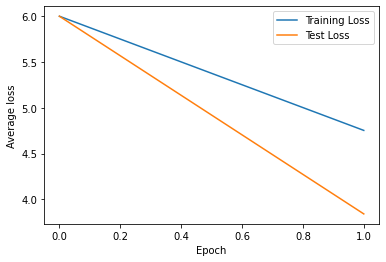

-------------------------------------------------------------------------------
Epoch starting at: 13:30:48
Epoch: 2, batch: 178/178, loss: 3.37958
Test Error:
Acc@1: 18.45%, Acc@5: 49.79%, Acc@10: 64.25%, Acc@20: 76.96% Avg loss: 3.688689
Epoch duration: 1:17


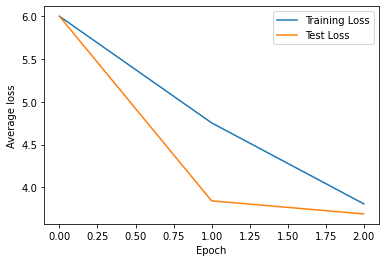

-------------------------------------------------------------------------------
Epoch starting at: 13:32:12
Epoch: 3, batch: 178/178, loss: 2.90763
Test Error:
Acc@1: 19.41%, Acc@5: 50.87%, Acc@10: 64.68%, Acc@20: 77.15% Avg loss: 3.624778
Epoch duration: 1:18


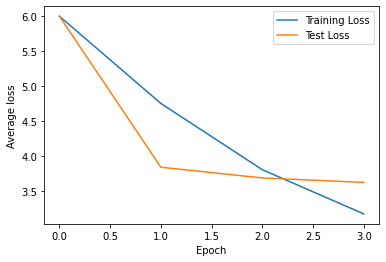

-------------------------------------------------------------------------------
Epoch starting at: 13:33:37
Epoch: 4, batch: 178/178, loss: 2.39642
Test Error:
Acc@1: 19.87%, Acc@5: 50.17%, Acc@10: 63.64%, Acc@20: 76.51% Avg loss: 3.631455
Epoch duration: 1:17


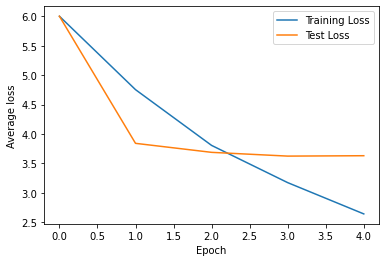

-------------------------------------------------------------------------------
Epoch starting at: 13:35:02
Epoch: 5, batch: 178/178, loss: 1.97328
Test Error:
Acc@1: 19.13%, Acc@5: 49.95%, Acc@10: 63.70%, Acc@20: 77.10% Avg loss: 3.649997
Epoch duration: 1:18


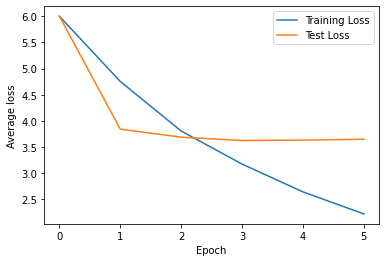





Current iteration 1/36
- Initial learning rate: 0.001
- Model: 

 HCPNN(
  (skill_embedding): Linear(in_features=317, out_features=100, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=50, bias=False)
  (license_embedding): Linear(in_features=8, out_features=10, bias=False)
  (language_embedding): Linear(in_features=23, out_features=15, bias=False)
  (address_embedding): Embedding(4768, 25)
  (function_embedding): Embedding(2993, 250)
  (isco_code_embedding): Embedding(355, 150)
  (company_embedding): Embedding(441153, 300)
  (source_embedding): Embedding(2, 1)
  (education_embedding): Embedding(6, 10)
  (isco_level_embedding): Embedding(5, 10)
  (LSTMs): ModuleList(
    (0): LSTM(1021, 500, batch_first=True)
  )
  (attention): attention(
    (att_fc): Linear(in_features=500, out_features=1, bias=True)
  )
  (dropout): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=700, out_features=355, bias=True)
  (softmax): LogSoftmax(dim=-1)
) 

-----------------

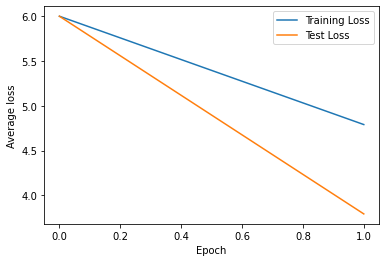

-------------------------------------------------------------------------------
Epoch starting at: 13:37:48
Epoch: 2, batch: 178/178, loss: 3.58854
Test Error:
Acc@1: 18.18%, Acc@5: 48.74%, Acc@10: 62.90%, Acc@20: 75.99% Avg loss: 3.779126
Epoch duration: 1:17


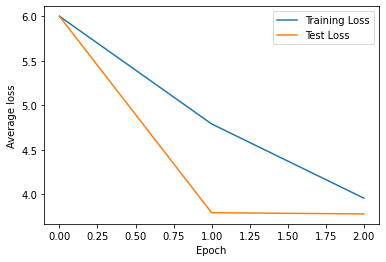

-------------------------------------------------------------------------------
Epoch starting at: 13:39:05
Epoch: 3, batch: 178/178, loss: 3.14842
Test Error:
Acc@1: 18.55%, Acc@5: 48.76%, Acc@10: 63.13%, Acc@20: 75.83% Avg loss: 3.712710
Epoch duration: 1:18


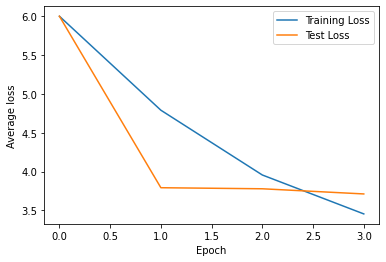

-------------------------------------------------------------------------------
Epoch starting at: 13:40:24
Epoch: 4, batch: 178/178, loss: 2.75230
Test Error:
Acc@1: 18.19%, Acc@5: 49.05%, Acc@10: 63.64%, Acc@20: 76.63% Avg loss: 3.650715
Epoch duration: 1:18


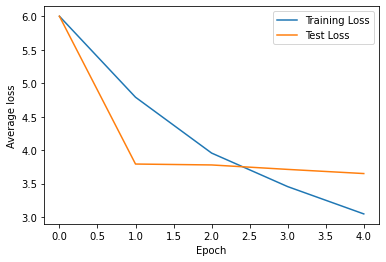

-------------------------------------------------------------------------------
Epoch starting at: 13:41:42
Epoch: 5, batch: 178/178, loss: 2.66233
Test Error:
Acc@1: 17.69%, Acc@5: 47.94%, Acc@10: 62.36%, Acc@20: 75.47% Avg loss: 3.705605
Epoch duration: 1:19


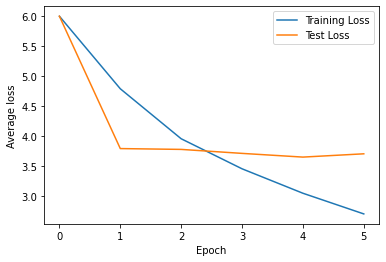





Current iteration 2/36
- Initial learning rate: 0.001
- Model: 

 HCPNN(
  (skill_embedding): Linear(in_features=317, out_features=100, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=50, bias=False)
  (license_embedding): Linear(in_features=8, out_features=10, bias=False)
  (language_embedding): Linear(in_features=23, out_features=15, bias=False)
  (address_embedding): Embedding(4768, 25)
  (function_embedding): Embedding(2993, 250)
  (isco_code_embedding): Embedding(355, 150)
  (company_embedding): Embedding(441153, 300)
  (source_embedding): Embedding(2, 1)
  (education_embedding): Embedding(6, 10)
  (isco_level_embedding): Embedding(5, 10)
  (LSTMs): ModuleList(
    (0): LSTM(1021, 500, batch_first=True)
  )
  (attention): attention(
    (att_fc): Linear(in_features=500, out_features=1, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=700, out_features=355, bias=True)
  (softmax): LogSoftmax(dim=-1)
) 

------------------

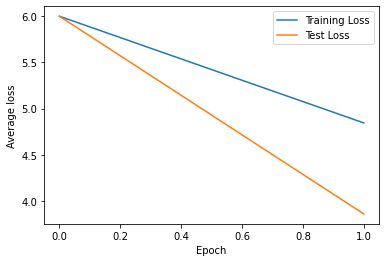

-------------------------------------------------------------------------------
Epoch starting at: 13:44:29
Epoch: 2, batch: 178/178, loss: 3.95062
Test Error:
Acc@1: 17.90%, Acc@5: 47.87%, Acc@10: 62.66%, Acc@20: 75.49% Avg loss: 3.797625
Epoch duration: 1:18


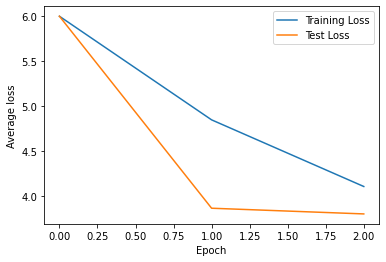

-------------------------------------------------------------------------------
Epoch starting at: 13:45:48
Epoch: 3, batch: 178/178, loss: 3.48982
Test Error:
Acc@1: 18.73%, Acc@5: 49.28%, Acc@10: 63.02%, Acc@20: 75.74% Avg loss: 3.719104
Epoch duration: 1:18


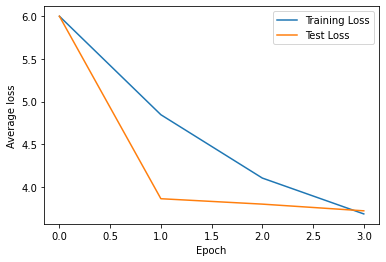

-------------------------------------------------------------------------------
Epoch starting at: 13:47:13
Epoch: 4, batch: 178/178, loss: 3.24230
Test Error:
Acc@1: 18.78%, Acc@5: 48.60%, Acc@10: 62.53%, Acc@20: 75.51% Avg loss: 3.699065
Epoch duration: 1:17


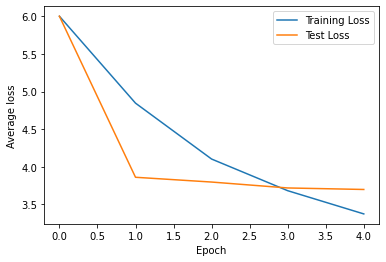

-------------------------------------------------------------------------------
Epoch starting at: 13:48:37
Epoch: 5, batch: 178/178, loss: 2.81588
Test Error:
Acc@1: 17.75%, Acc@5: 47.36%, Acc@10: 61.39%, Acc@20: 75.42% Avg loss: 3.724046
Epoch duration: 1:18


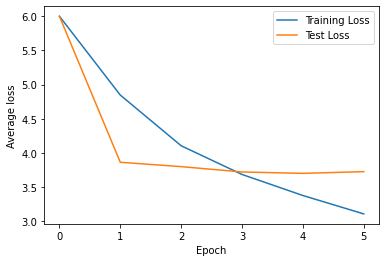





Current iteration 3/36
- Initial learning rate: 0.001
- Model: 

 HCPNN(
  (skill_embedding): Linear(in_features=317, out_features=100, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=50, bias=False)
  (license_embedding): Linear(in_features=8, out_features=10, bias=False)
  (language_embedding): Linear(in_features=23, out_features=15, bias=False)
  (address_embedding): Embedding(4768, 25)
  (function_embedding): Embedding(2993, 250)
  (isco_code_embedding): Embedding(355, 150)
  (company_embedding): Embedding(441153, 300)
  (source_embedding): Embedding(2, 1)
  (education_embedding): Embedding(6, 10)
  (isco_level_embedding): Embedding(5, 10)
  (LSTMs): ModuleList(
    (0): LSTM(1021, 1000, batch_first=True)
  )
  (attention): attention(
    (att_fc): Linear(in_features=1000, out_features=1, bias=True)
  )
  (dropout): Dropout(p=0, inplace=False)
  (fc): Linear(in_features=1200, out_features=355, bias=True)
  (softmax): LogSoftmax(dim=-1)
) 

-----------------

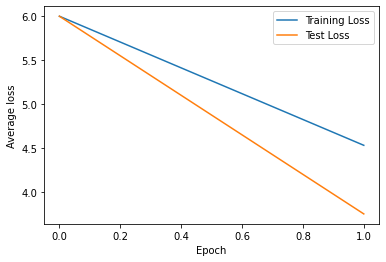

-------------------------------------------------------------------------------
Epoch starting at: 13:51:56
Epoch: 2, batch: 178/178, loss: 3.01030
Test Error:
Acc@1: 18.04%, Acc@5: 47.31%, Acc@10: 61.15%, Acc@20: 74.93% Avg loss: 3.745620
Epoch duration: 1:50


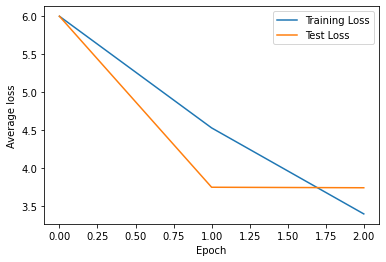

-------------------------------------------------------------------------------
Epoch starting at: 13:53:47
Epoch: 3, batch: 178/178, loss: 2.22716
Test Error:
Acc@1: 20.63%, Acc@5: 50.22%, Acc@10: 64.19%, Acc@20: 77.03% Avg loss: 3.589761
Epoch duration: 1:51


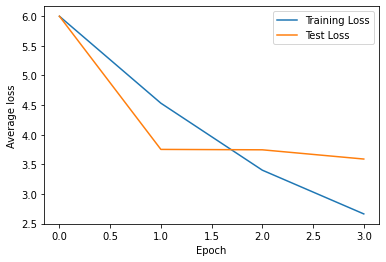

-------------------------------------------------------------------------------
Epoch starting at: 13:55:45
Epoch: 4, batch: 178/178, loss: 1.80447
Test Error:
Acc@1: 19.75%, Acc@5: 49.49%, Acc@10: 63.35%, Acc@20: 76.64% Avg loss: 3.656663
Epoch duration: 1:50


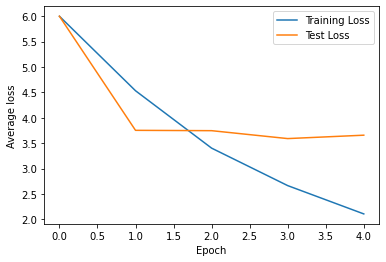

-------------------------------------------------------------------------------
Epoch starting at: 13:57:36
Epoch: 5, batch: 178/178, loss: 1.42010
Test Error:
Acc@1: 19.79%, Acc@5: 48.72%, Acc@10: 63.06%, Acc@20: 76.44% Avg loss: 3.736513
Epoch duration: 1:51


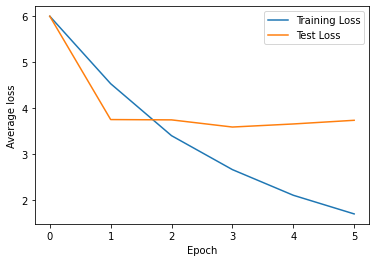





Current iteration 4/36
- Initial learning rate: 0.001
- Model: 

 HCPNN(
  (skill_embedding): Linear(in_features=317, out_features=100, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=50, bias=False)
  (license_embedding): Linear(in_features=8, out_features=10, bias=False)
  (language_embedding): Linear(in_features=23, out_features=15, bias=False)
  (address_embedding): Embedding(4768, 25)
  (function_embedding): Embedding(2993, 250)
  (isco_code_embedding): Embedding(355, 150)
  (company_embedding): Embedding(441153, 300)
  (source_embedding): Embedding(2, 1)
  (education_embedding): Embedding(6, 10)
  (isco_level_embedding): Embedding(5, 10)
  (LSTMs): ModuleList(
    (0): LSTM(1021, 1000, batch_first=True)
  )
  (attention): attention(
    (att_fc): Linear(in_features=1000, out_features=1, bias=True)
  )
  (dropout): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=1200, out_features=355, bias=True)
  (softmax): LogSoftmax(dim=-1)
) 

--------------

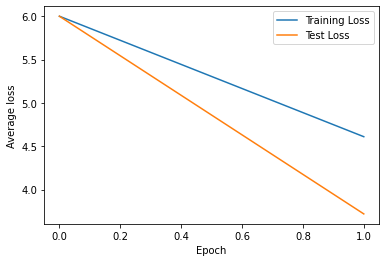

-------------------------------------------------------------------------------
Epoch starting at: 14:01:28
Epoch: 2, batch: 178/178, loss: 3.27175
Test Error:
Acc@1: 18.65%, Acc@5: 48.76%, Acc@10: 63.52%, Acc@20: 76.62% Avg loss: 3.702334
Epoch duration: 1:52


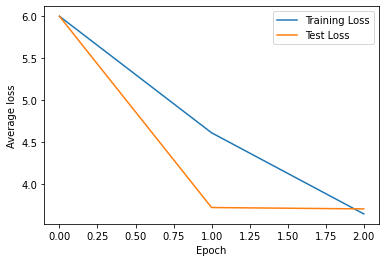

-------------------------------------------------------------------------------
Epoch starting at: 14:03:20
Epoch: 3, batch: 178/178, loss: 2.89022
Test Error:
Acc@1: 19.16%, Acc@5: 48.74%, Acc@10: 62.81%, Acc@20: 76.22% Avg loss: 3.650938
Epoch duration: 1:52


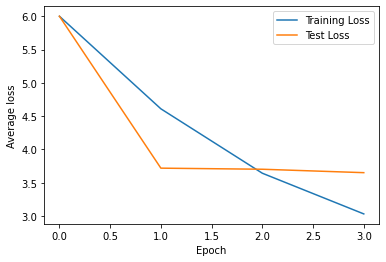

-------------------------------------------------------------------------------
Epoch starting at: 14:05:13
Epoch: 4, batch: 178/178, loss: 2.45267
Test Error:
Acc@1: 18.96%, Acc@5: 48.71%, Acc@10: 62.93%, Acc@20: 76.50% Avg loss: 3.632188
Epoch duration: 1:51


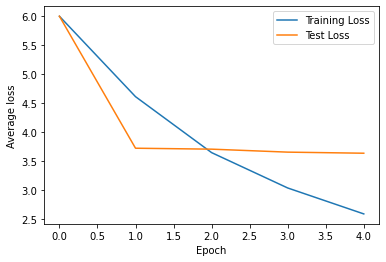

-------------------------------------------------------------------------------
Epoch starting at: 14:07:04
Epoch: 5, batch: 178/178, loss: 2.01224
Test Error:
Acc@1: 19.23%, Acc@5: 48.24%, Acc@10: 62.63%, Acc@20: 76.20% Avg loss: 3.665700
Epoch duration: 1:51


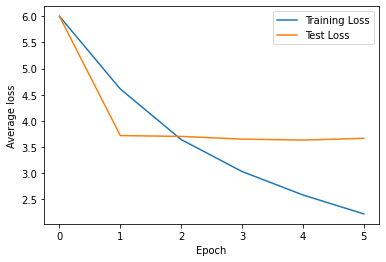





Current iteration 5/36
- Initial learning rate: 0.001
- Model: 

 HCPNN(
  (skill_embedding): Linear(in_features=317, out_features=100, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=50, bias=False)
  (license_embedding): Linear(in_features=8, out_features=10, bias=False)
  (language_embedding): Linear(in_features=23, out_features=15, bias=False)
  (address_embedding): Embedding(4768, 25)
  (function_embedding): Embedding(2993, 250)
  (isco_code_embedding): Embedding(355, 150)
  (company_embedding): Embedding(441153, 300)
  (source_embedding): Embedding(2, 1)
  (education_embedding): Embedding(6, 10)
  (isco_level_embedding): Embedding(5, 10)
  (LSTMs): ModuleList(
    (0): LSTM(1021, 1000, batch_first=True)
  )
  (attention): attention(
    (att_fc): Linear(in_features=1000, out_features=1, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=1200, out_features=355, bias=True)
  (softmax): LogSoftmax(dim=-1)
) 

---------------

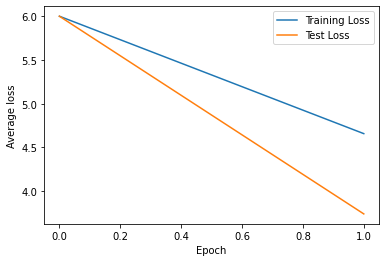

-------------------------------------------------------------------------------
Epoch starting at: 14:10:56
Epoch: 2, batch: 178/178, loss: 3.63794
Test Error:
Acc@1: 18.62%, Acc@5: 49.03%, Acc@10: 63.28%, Acc@20: 76.03% Avg loss: 3.710999
Epoch duration: 1:52


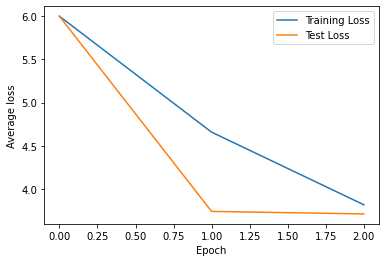

-------------------------------------------------------------------------------
Epoch starting at: 14:12:49
Epoch: 3, batch: 178/178, loss: 3.18343
Test Error:
Acc@1: 18.91%, Acc@5: 47.72%, Acc@10: 61.57%, Acc@20: 74.94% Avg loss: 3.710080
Epoch duration: 1:52


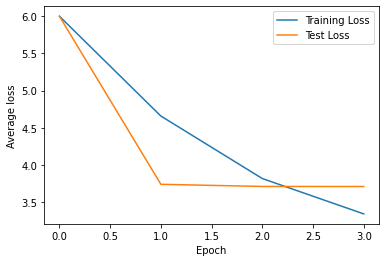

-------------------------------------------------------------------------------
Epoch starting at: 14:14:42
Epoch: 4, batch: 178/178, loss: 2.82134
Test Error:
Acc@1: 17.46%, Acc@5: 47.11%, Acc@10: 61.58%, Acc@20: 75.23% Avg loss: 3.710220
Epoch duration: 1:51


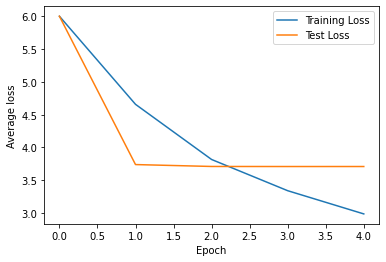

-------------------------------------------------------------------------------
Epoch starting at: 14:16:33
Epoch: 5, batch: 178/178, loss: 2.53957
Test Error:
Acc@1: 18.68%, Acc@5: 47.05%, Acc@10: 61.34%, Acc@20: 74.78% Avg loss: 3.691616
Epoch duration: 1:51


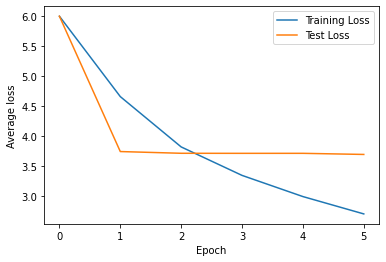





Current iteration 6/36
- Initial learning rate: 0.001
- Model: 

 HCPNN(
  (skill_embedding): Linear(in_features=317, out_features=100, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=50, bias=False)
  (license_embedding): Linear(in_features=8, out_features=10, bias=False)
  (language_embedding): Linear(in_features=23, out_features=15, bias=False)
  (address_embedding): Embedding(4768, 25)
  (function_embedding): Embedding(2993, 250)
  (isco_code_embedding): Embedding(355, 150)
  (company_embedding): Embedding(441153, 300)
  (source_embedding): Embedding(2, 1)
  (education_embedding): Embedding(6, 10)
  (isco_level_embedding): Embedding(5, 10)
  (LSTMs): ModuleList(
    (0): LSTM(1021, 1500, batch_first=True)
  )
  (attention): attention(
    (att_fc): Linear(in_features=1500, out_features=1, bias=True)
  )
  (dropout): Dropout(p=0, inplace=False)
  (fc): Linear(in_features=1700, out_features=355, bias=True)
  (softmax): LogSoftmax(dim=-1)
) 

-----------------

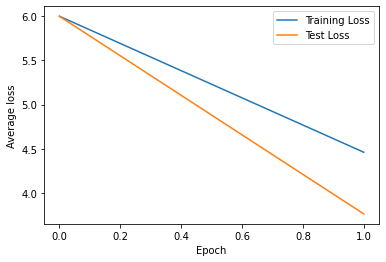

-------------------------------------------------------------------------------
Epoch starting at: 14:21:18
Epoch: 2, batch: 178/178, loss: 2.67052
Test Error:
Acc@1: 20.45%, Acc@5: 50.14%, Acc@10: 63.97%, Acc@20: 76.62% Avg loss: 3.597320
Epoch duration: 2:44


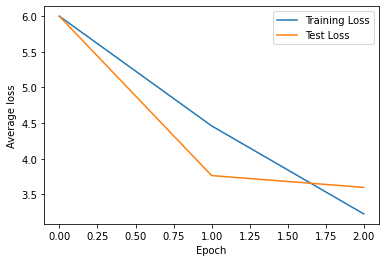

-------------------------------------------------------------------------------
Epoch starting at: 14:24:09
Epoch: 3, batch: 178/178, loss: 1.96240
Test Error:
Acc@1: 20.13%, Acc@5: 49.67%, Acc@10: 63.72%, Acc@20: 76.73% Avg loss: 3.636479
Epoch duration: 2:45


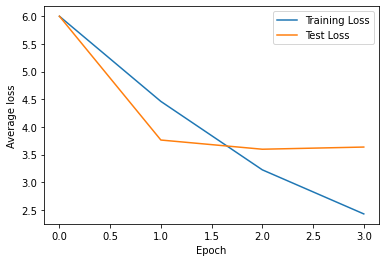

-------------------------------------------------------------------------------
Epoch starting at: 14:26:55
Epoch: 4, batch: 178/178, loss: 1.75633
Test Error:
Acc@1: 19.78%, Acc@5: 48.91%, Acc@10: 63.08%, Acc@20: 76.45% Avg loss: 3.693342
Epoch duration: 2:44


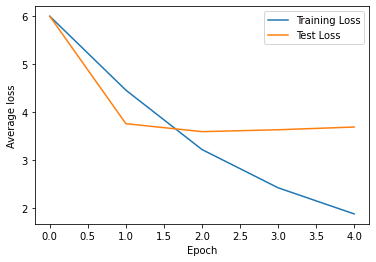

-------------------------------------------------------------------------------
Epoch starting at: 14:29:40
Epoch: 5, batch: 178/178, loss: 1.37466
Test Error:
Acc@1: 19.36%, Acc@5: 49.75%, Acc@10: 63.78%, Acc@20: 76.94% Avg loss: 3.768238
Epoch duration: 2:45


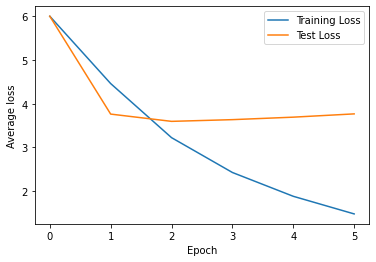





Current iteration 7/36
- Initial learning rate: 0.001
- Model: 

 HCPNN(
  (skill_embedding): Linear(in_features=317, out_features=100, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=50, bias=False)
  (license_embedding): Linear(in_features=8, out_features=10, bias=False)
  (language_embedding): Linear(in_features=23, out_features=15, bias=False)
  (address_embedding): Embedding(4768, 25)
  (function_embedding): Embedding(2993, 250)
  (isco_code_embedding): Embedding(355, 150)
  (company_embedding): Embedding(441153, 300)
  (source_embedding): Embedding(2, 1)
  (education_embedding): Embedding(6, 10)
  (isco_level_embedding): Embedding(5, 10)
  (LSTMs): ModuleList(
    (0): LSTM(1021, 1500, batch_first=True)
  )
  (attention): attention(
    (att_fc): Linear(in_features=1500, out_features=1, bias=True)
  )
  (dropout): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=1700, out_features=355, bias=True)
  (softmax): LogSoftmax(dim=-1)
) 

--------------

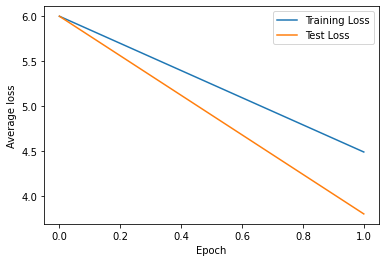

-------------------------------------------------------------------------------
Epoch starting at: 14:35:19
Epoch: 2, batch: 178/178, loss: 3.07620
Test Error:
Acc@1: 18.25%, Acc@5: 48.16%, Acc@10: 61.99%, Acc@20: 75.01% Avg loss: 3.688957
Epoch duration: 2:45


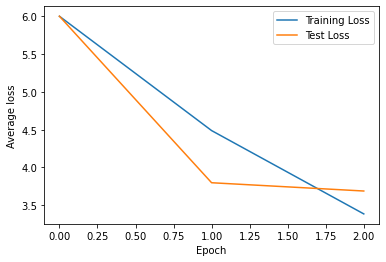

-------------------------------------------------------------------------------
Epoch starting at: 14:38:12
Epoch: 3, batch: 178/178, loss: 2.39174
Test Error:
Acc@1: 19.01%, Acc@5: 48.59%, Acc@10: 62.54%, Acc@20: 75.40% Avg loss: 3.647203
Epoch duration: 2:44


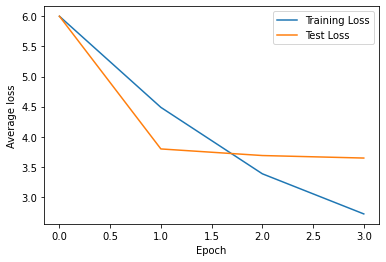

-------------------------------------------------------------------------------
Epoch starting at: 14:41:04
Epoch: 4, batch: 178/178, loss: 1.97442
Test Error:
Acc@1: 18.18%, Acc@5: 47.49%, Acc@10: 62.03%, Acc@20: 75.70% Avg loss: 3.690874
Epoch duration: 2:45


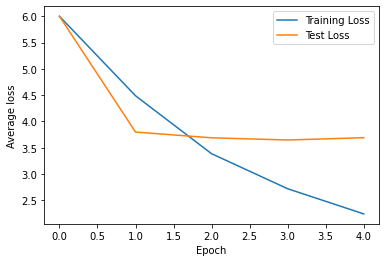

-------------------------------------------------------------------------------
Epoch starting at: 14:43:50
Epoch: 5, batch: 178/178, loss: 1.60586
Test Error:
Acc@1: 19.75%, Acc@5: 48.53%, Acc@10: 63.16%, Acc@20: 76.14% Avg loss: 3.699698
Epoch duration: 2:45


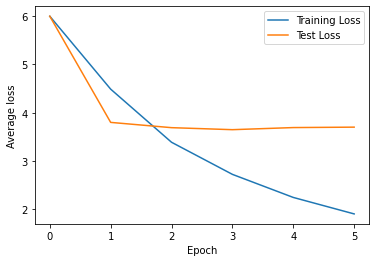





Current iteration 8/36
- Initial learning rate: 0.001
- Model: 

 HCPNN(
  (skill_embedding): Linear(in_features=317, out_features=100, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=50, bias=False)
  (license_embedding): Linear(in_features=8, out_features=10, bias=False)
  (language_embedding): Linear(in_features=23, out_features=15, bias=False)
  (address_embedding): Embedding(4768, 25)
  (function_embedding): Embedding(2993, 250)
  (isco_code_embedding): Embedding(355, 150)
  (company_embedding): Embedding(441153, 300)
  (source_embedding): Embedding(2, 1)
  (education_embedding): Embedding(6, 10)
  (isco_level_embedding): Embedding(5, 10)
  (LSTMs): ModuleList(
    (0): LSTM(1021, 1500, batch_first=True)
  )
  (attention): attention(
    (att_fc): Linear(in_features=1500, out_features=1, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=1700, out_features=355, bias=True)
  (softmax): LogSoftmax(dim=-1)
) 

---------------

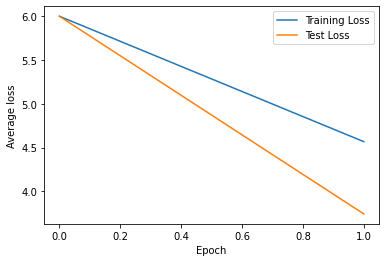

-------------------------------------------------------------------------------
Epoch starting at: 14:49:36
Epoch: 2, batch: 178/178, loss: 3.44790
Test Error:
Acc@1: 19.64%, Acc@5: 48.64%, Acc@10: 62.36%, Acc@20: 75.61% Avg loss: 3.678184
Epoch duration: 2:45


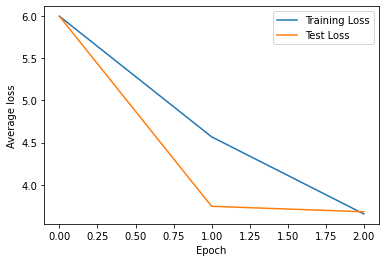

-------------------------------------------------------------------------------
Epoch starting at: 14:52:22
Epoch: 3, batch: 178/178, loss: 2.90166
Test Error:
Acc@1: 19.07%, Acc@5: 47.84%, Acc@10: 61.98%, Acc@20: 75.31% Avg loss: 3.682365
Epoch duration: 2:44


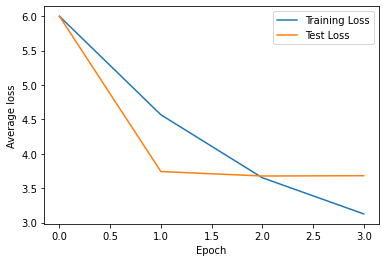

-------------------------------------------------------------------------------
Epoch starting at: 14:55:07
Epoch: 4, batch: 178/178, loss: 2.62162
Test Error:
Acc@1: 19.02%, Acc@5: 46.74%, Acc@10: 60.91%, Acc@20: 74.67% Avg loss: 3.711767
Epoch duration: 2:46


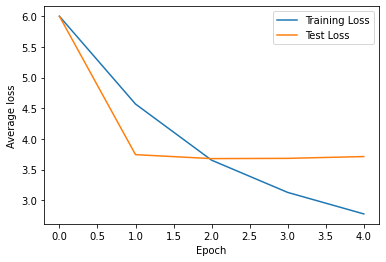

-------------------------------------------------------------------------------
Epoch starting at: 14:57:53
Epoch: 5, batch: 178/178, loss: 2.21593
Test Error:
Acc@1: 18.73%, Acc@5: 47.36%, Acc@10: 61.57%, Acc@20: 75.56% Avg loss: 3.702542
Epoch duration: 2:44


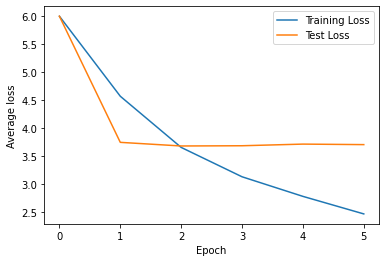





Current iteration 9/36
- Initial learning rate: 0.001
- Model: 

 HCPNN(
  (skill_embedding): Linear(in_features=317, out_features=100, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=50, bias=False)
  (license_embedding): Linear(in_features=8, out_features=10, bias=False)
  (language_embedding): Linear(in_features=23, out_features=15, bias=False)
  (address_embedding): Embedding(4768, 25)
  (function_embedding): Embedding(2993, 250)
  (isco_code_embedding): Embedding(355, 150)
  (company_embedding): Embedding(441153, 300)
  (source_embedding): Embedding(2, 1)
  (education_embedding): Embedding(6, 10)
  (isco_level_embedding): Embedding(5, 10)
  (LSTMs): ModuleList(
    (0): LSTM(1021, 2500, batch_first=True)
  )
  (attention): attention(
    (att_fc): Linear(in_features=2500, out_features=1, bias=True)
  )
  (dropout): Dropout(p=0, inplace=False)
  (fc): Linear(in_features=2700, out_features=355, bias=True)
  (softmax): LogSoftmax(dim=-1)
) 

-----------------

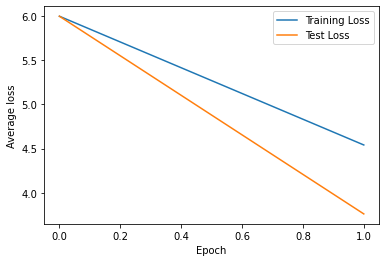

-------------------------------------------------------------------------------
Epoch starting at: 15:05:58
Epoch: 2, batch: 178/178, loss: 2.55844
Test Error:
Acc@1: 19.29%, Acc@5: 47.77%, Acc@10: 61.85%, Acc@20: 75.58% Avg loss: 3.655771
Epoch duration: 5:08


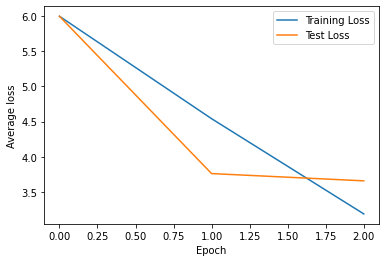

-------------------------------------------------------------------------------
Epoch starting at: 15:11:15
Epoch: 3, batch: 178/178, loss: 2.06200
Test Error:
Acc@1: 18.43%, Acc@5: 48.92%, Acc@10: 63.27%, Acc@20: 76.60% Avg loss: 3.670274
Epoch duration: 5:07


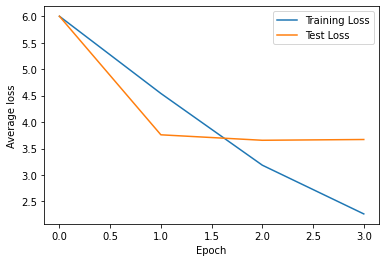

-------------------------------------------------------------------------------
Epoch starting at: 15:16:23
Epoch: 4, batch: 178/178, loss: 1.51389
Test Error:
Acc@1: 20.01%, Acc@5: 49.72%, Acc@10: 64.30%, Acc@20: 76.95% Avg loss: 3.714275
Epoch duration: 5:09


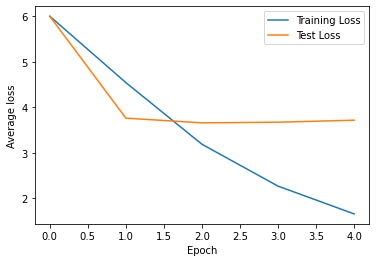

-------------------------------------------------------------------------------
Epoch starting at: 15:21:40
Epoch: 5, batch: 178/178, loss: 1.11728
Test Error:
Acc@1: 19.95%, Acc@5: 49.54%, Acc@10: 63.74%, Acc@20: 76.86% Avg loss: 3.817389
Epoch duration: 5:07


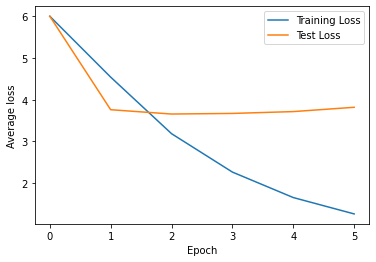





Current iteration 10/36
- Initial learning rate: 0.001
- Model: 

 HCPNN(
  (skill_embedding): Linear(in_features=317, out_features=100, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=50, bias=False)
  (license_embedding): Linear(in_features=8, out_features=10, bias=False)
  (language_embedding): Linear(in_features=23, out_features=15, bias=False)
  (address_embedding): Embedding(4768, 25)
  (function_embedding): Embedding(2993, 250)
  (isco_code_embedding): Embedding(355, 150)
  (company_embedding): Embedding(441153, 300)
  (source_embedding): Embedding(2, 1)
  (education_embedding): Embedding(6, 10)
  (isco_level_embedding): Embedding(5, 10)
  (LSTMs): ModuleList(
    (0): LSTM(1021, 2500, batch_first=True)
  )
  (attention): attention(
    (att_fc): Linear(in_features=2500, out_features=1, bias=True)
  )
  (dropout): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=2700, out_features=355, bias=True)
  (softmax): LogSoftmax(dim=-1)
) 

-------------

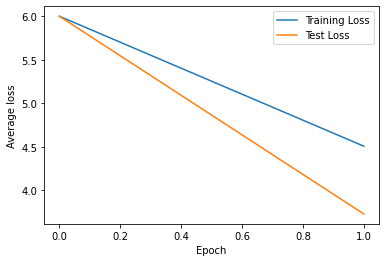

-------------------------------------------------------------------------------
Epoch starting at: 15:32:08
Epoch: 2, batch: 178/178, loss: 2.80119
Test Error:
Acc@1: 19.41%, Acc@5: 48.97%, Acc@10: 62.50%, Acc@20: 75.68% Avg loss: 3.626285
Epoch duration: 5:09


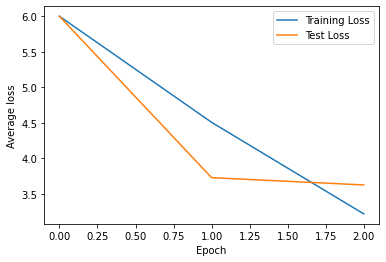

-------------------------------------------------------------------------------
Epoch starting at: 15:37:26
Epoch: 3, batch: 178/178, loss: 2.21095
Test Error:
Acc@1: 19.22%, Acc@5: 48.77%, Acc@10: 63.14%, Acc@20: 76.48% Avg loss: 3.622821
Epoch duration: 5:08


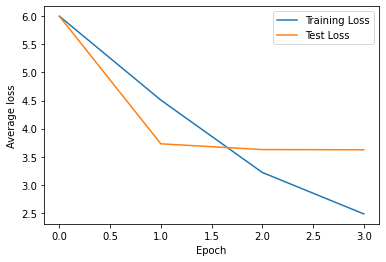

-------------------------------------------------------------------------------
Epoch starting at: 15:42:35
Epoch: 4, batch: 178/178, loss: 1.64832
Test Error:
Acc@1: 18.15%, Acc@5: 47.94%, Acc@10: 62.12%, Acc@20: 75.81% Avg loss: 3.730773
Epoch duration: 5:10


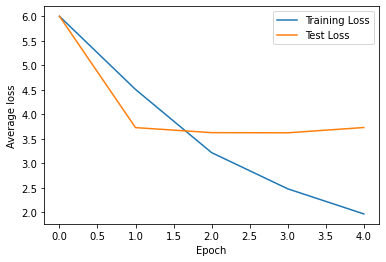

-------------------------------------------------------------------------------
Epoch starting at: 15:47:46
Epoch: 5, batch: 178/178, loss: 1.39135
Test Error:
Acc@1: 18.22%, Acc@5: 47.38%, Acc@10: 62.22%, Acc@20: 76.19% Avg loss: 3.805461
Epoch duration: 5:09


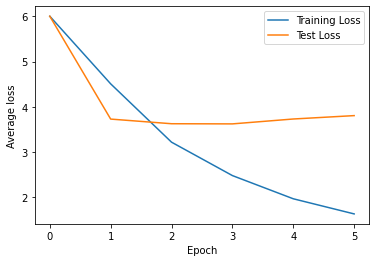





Current iteration 11/36
- Initial learning rate: 0.001
- Model: 

 HCPNN(
  (skill_embedding): Linear(in_features=317, out_features=100, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=50, bias=False)
  (license_embedding): Linear(in_features=8, out_features=10, bias=False)
  (language_embedding): Linear(in_features=23, out_features=15, bias=False)
  (address_embedding): Embedding(4768, 25)
  (function_embedding): Embedding(2993, 250)
  (isco_code_embedding): Embedding(355, 150)
  (company_embedding): Embedding(441153, 300)
  (source_embedding): Embedding(2, 1)
  (education_embedding): Embedding(6, 10)
  (isco_level_embedding): Embedding(5, 10)
  (LSTMs): ModuleList(
    (0): LSTM(1021, 2500, batch_first=True)
  )
  (attention): attention(
    (att_fc): Linear(in_features=2500, out_features=1, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=2700, out_features=355, bias=True)
  (softmax): LogSoftmax(dim=-1)
) 

--------------

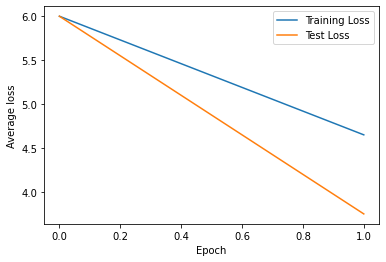

-------------------------------------------------------------------------------
Epoch starting at: 15:58:16
Epoch: 2, batch: 178/178, loss: 3.03977
Test Error:
Acc@1: 19.60%, Acc@5: 48.71%, Acc@10: 61.89%, Acc@20: 74.67% Avg loss: 3.642432
Epoch duration: 5:09


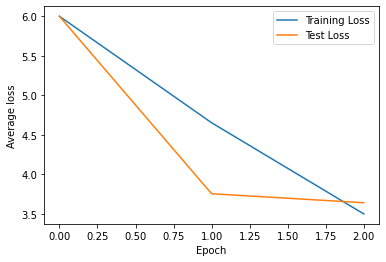

-------------------------------------------------------------------------------
Epoch starting at: 16:03:33
Epoch: 3, batch: 178/178, loss: 3.02828
Test Error:
Acc@1: 19.67%, Acc@5: 48.42%, Acc@10: 62.30%, Acc@20: 75.70% Avg loss: 3.659961
Epoch duration: 5:08


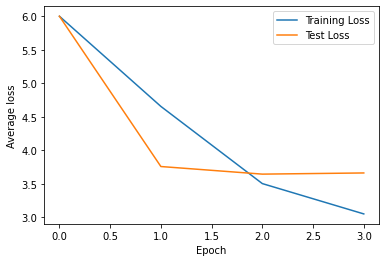

-------------------------------------------------------------------------------
Epoch starting at: 16:08:50
Epoch: 4, batch: 178/178, loss: 2.90323
Test Error:
Acc@1: 17.76%, Acc@5: 47.24%, Acc@10: 61.18%, Acc@20: 75.05% Avg loss: 3.732750
Epoch duration: 5:09


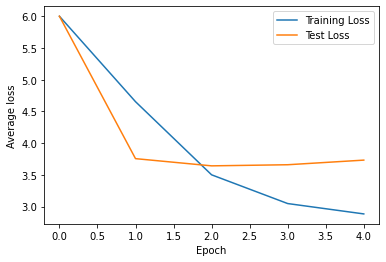

-------------------------------------------------------------------------------
Epoch starting at: 16:13:59
Epoch: 5, batch: 178/178, loss: 2.06752
Test Error:
Acc@1: 17.74%, Acc@5: 46.40%, Acc@10: 61.13%, Acc@20: 74.75% Avg loss: 3.729504
Epoch duration: 5:08


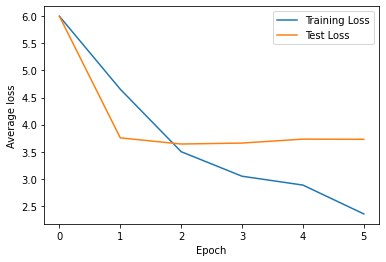





Current iteration 12/36
- Initial learning rate: 0.001
- Model: 

 HCPNN(
  (skill_embedding): Linear(in_features=317, out_features=100, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=50, bias=False)
  (license_embedding): Linear(in_features=8, out_features=10, bias=False)
  (language_embedding): Linear(in_features=23, out_features=15, bias=False)
  (address_embedding): Embedding(4768, 25)
  (function_embedding): Embedding(2993, 250)
  (isco_code_embedding): Embedding(355, 150)
  (company_embedding): Embedding(441153, 300)
  (source_embedding): Embedding(2, 1)
  (education_embedding): Embedding(6, 10)
  (isco_level_embedding): Embedding(5, 10)
  (LSTMs): ModuleList(
    (0): LSTM(1021, 500, batch_first=True)
    (1): LSTM(500, 500, batch_first=True)
    (2): LSTM(500, 500, batch_first=True)
    (3): LSTM(500, 500, batch_first=True)
    (4): LSTM(500, 500, batch_first=True)
  )
  (attention): attention(
    (att_fc): Linear(in_features=500, out_features=1, bias

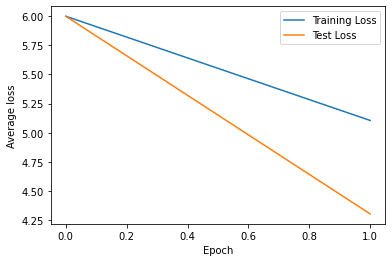

-------------------------------------------------------------------------------
Epoch starting at: 16:21:47
Epoch: 2, batch: 178/178, loss: 4.78775
Test Error:
Acc@1: 12.88%, Acc@5: 39.58%, Acc@10: 53.64%, Acc@20: 67.48% Avg loss: 4.294766
Epoch duration: 2:28


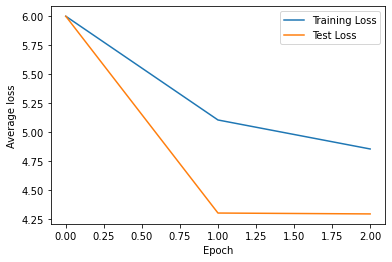

-------------------------------------------------------------------------------
Epoch starting at: 16:24:23
Epoch: 3, batch: 178/178, loss: 4.43969
Test Error:
Acc@1: 12.92%, Acc@5: 41.86%, Acc@10: 55.19%, Acc@20: 69.39% Avg loss: 4.079289
Epoch duration: 2:29


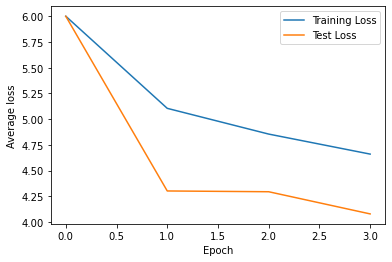

-------------------------------------------------------------------------------
Epoch starting at: 16:26:59
Epoch: 4, batch: 178/178, loss: 3.98279
Test Error:
Acc@1: 12.38%, Acc@5: 42.05%, Acc@10: 56.68%, Acc@20: 70.26% Avg loss: 4.012633
Epoch duration: 2:30


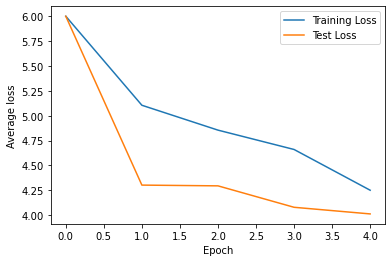

-------------------------------------------------------------------------------
Epoch starting at: 16:29:30
Epoch: 5, batch: 178/178, loss: 3.75211
Test Error:
Acc@1: 13.26%, Acc@5: 42.59%, Acc@10: 56.85%, Acc@20: 70.91% Avg loss: 3.916041
Epoch duration: 2:30


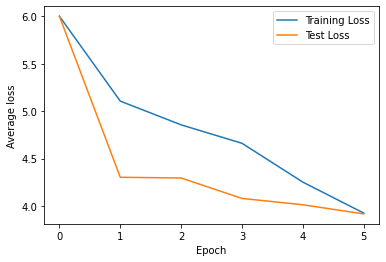





Current iteration 13/36
- Initial learning rate: 0.001
- Model: 

 HCPNN(
  (skill_embedding): Linear(in_features=317, out_features=100, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=50, bias=False)
  (license_embedding): Linear(in_features=8, out_features=10, bias=False)
  (language_embedding): Linear(in_features=23, out_features=15, bias=False)
  (address_embedding): Embedding(4768, 25)
  (function_embedding): Embedding(2993, 250)
  (isco_code_embedding): Embedding(355, 150)
  (company_embedding): Embedding(441153, 300)
  (source_embedding): Embedding(2, 1)
  (education_embedding): Embedding(6, 10)
  (isco_level_embedding): Embedding(5, 10)
  (LSTMs): ModuleList(
    (0): LSTM(1021, 500, batch_first=True)
    (1): LSTM(500, 500, batch_first=True)
    (2): LSTM(500, 500, batch_first=True)
    (3): LSTM(500, 500, batch_first=True)
    (4): LSTM(500, 500, batch_first=True)
  )
  (attention): attention(
    (att_fc): Linear(in_features=500, out_features=1, bias

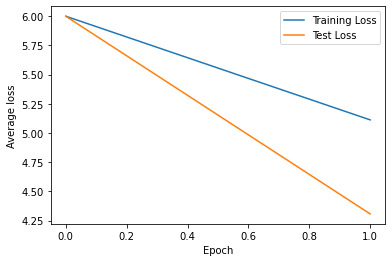

-------------------------------------------------------------------------------
Epoch starting at: 16:34:48
Epoch: 2, batch: 178/178, loss: 4.76429
Test Error:
Acc@1: 13.19%, Acc@5: 40.92%, Acc@10: 54.43%, Acc@20: 67.85% Avg loss: 4.284693
Epoch duration: 2:29


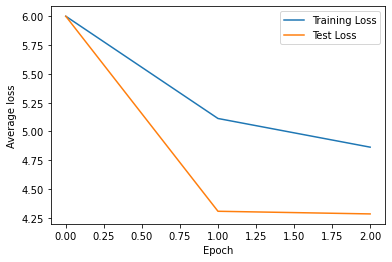

-------------------------------------------------------------------------------
Epoch starting at: 16:37:18
Epoch: 3, batch: 178/178, loss: 4.62331
Test Error:
Acc@1: 12.99%, Acc@5: 40.07%, Acc@10: 54.36%, Acc@20: 67.54% Avg loss: 4.278906
Epoch duration: 2:31


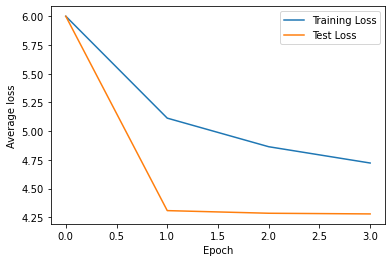

-------------------------------------------------------------------------------
Epoch starting at: 16:39:49
Epoch: 4, batch: 178/178, loss: 4.52808
Test Error:
Acc@1: 12.49%, Acc@5: 39.75%, Acc@10: 52.53%, Acc@20: 65.87% Avg loss: 4.328926
Epoch duration: 2:30


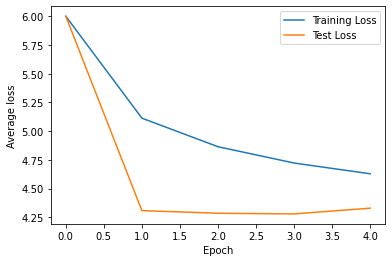

-------------------------------------------------------------------------------
Epoch starting at: 16:42:20
Epoch: 5, batch: 178/178, loss: 4.57355
Test Error:
Acc@1: 12.59%, Acc@5: 39.71%, Acc@10: 53.06%, Acc@20: 66.48% Avg loss: 4.300947
Epoch duration: 2:30


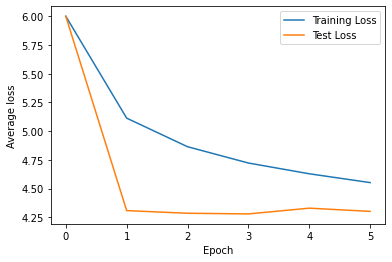





Current iteration 14/36
- Initial learning rate: 0.001
- Model: 

 HCPNN(
  (skill_embedding): Linear(in_features=317, out_features=100, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=50, bias=False)
  (license_embedding): Linear(in_features=8, out_features=10, bias=False)
  (language_embedding): Linear(in_features=23, out_features=15, bias=False)
  (address_embedding): Embedding(4768, 25)
  (function_embedding): Embedding(2993, 250)
  (isco_code_embedding): Embedding(355, 150)
  (company_embedding): Embedding(441153, 300)
  (source_embedding): Embedding(2, 1)
  (education_embedding): Embedding(6, 10)
  (isco_level_embedding): Embedding(5, 10)
  (LSTMs): ModuleList(
    (0): LSTM(1021, 500, batch_first=True)
    (1): LSTM(500, 500, batch_first=True)
    (2): LSTM(500, 500, batch_first=True)
    (3): LSTM(500, 500, batch_first=True)
    (4): LSTM(500, 500, batch_first=True)
  )
  (attention): attention(
    (att_fc): Linear(in_features=500, out_features=1, bias

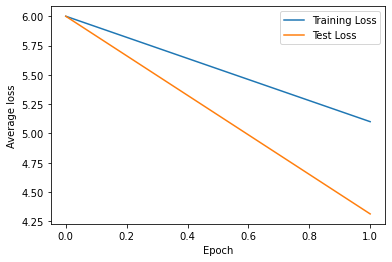

-------------------------------------------------------------------------------
Epoch starting at: 16:47:30
Epoch: 2, batch: 178/178, loss: 4.75774
Test Error:
Acc@1: 13.28%, Acc@5: 40.64%, Acc@10: 54.08%, Acc@20: 67.64% Avg loss: 4.270320
Epoch duration: 2:29


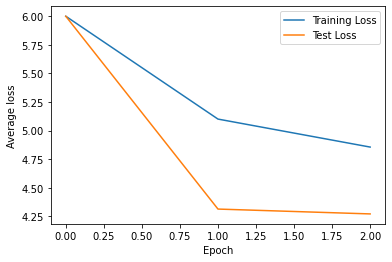

-------------------------------------------------------------------------------
Epoch starting at: 16:50:07
Epoch: 3, batch: 178/178, loss: 4.67483
Test Error:
Acc@1: 13.20%, Acc@5: 41.00%, Acc@10: 53.94%, Acc@20: 66.90% Avg loss: 4.253893
Epoch duration: 2:31


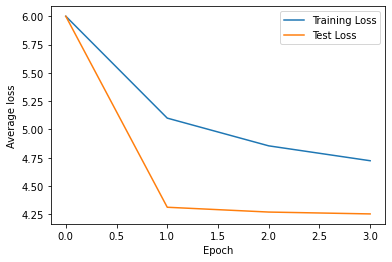

-------------------------------------------------------------------------------
Epoch starting at: 16:52:39
Epoch: 4, batch: 178/178, loss: 4.61221
Test Error:
Acc@1: 12.91%, Acc@5: 40.10%, Acc@10: 53.47%, Acc@20: 66.65% Avg loss: 4.264323
Epoch duration: 2:31


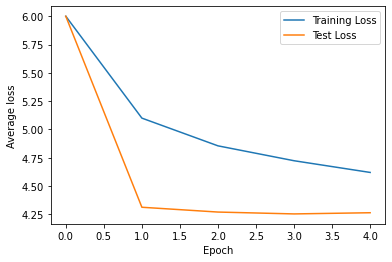

-------------------------------------------------------------------------------
Epoch starting at: 16:55:11
Epoch: 5, batch: 178/178, loss: 4.32137
Test Error:
Acc@1: 12.58%, Acc@5: 40.37%, Acc@10: 53.61%, Acc@20: 67.51% Avg loss: 4.152800
Epoch duration: 2:31


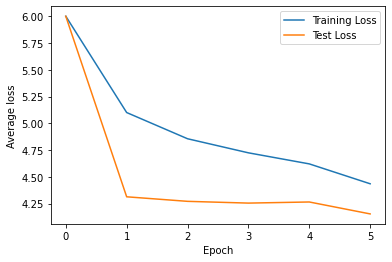





Current iteration 15/36
- Initial learning rate: 0.001
- Model: 

 HCPNN(
  (skill_embedding): Linear(in_features=317, out_features=100, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=50, bias=False)
  (license_embedding): Linear(in_features=8, out_features=10, bias=False)
  (language_embedding): Linear(in_features=23, out_features=15, bias=False)
  (address_embedding): Embedding(4768, 25)
  (function_embedding): Embedding(2993, 250)
  (isco_code_embedding): Embedding(355, 150)
  (company_embedding): Embedding(441153, 300)
  (source_embedding): Embedding(2, 1)
  (education_embedding): Embedding(6, 10)
  (isco_level_embedding): Embedding(5, 10)
  (LSTMs): ModuleList(
    (0): LSTM(1021, 1000, batch_first=True)
    (1): LSTM(1000, 1000, batch_first=True)
    (2): LSTM(1000, 1000, batch_first=True)
    (3): LSTM(1000, 1000, batch_first=True)
    (4): LSTM(1000, 1000, batch_first=True)
  )
  (attention): attention(
    (att_fc): Linear(in_features=1000, out_featur

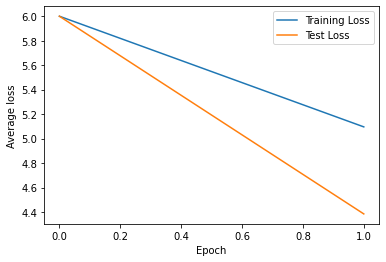

-------------------------------------------------------------------------------
Epoch starting at: 17:03:46
Epoch: 2, batch: 178/178, loss: 4.77796
Test Error:
Acc@1: 13.23%, Acc@5: 40.98%, Acc@10: 54.71%, Acc@20: 68.73% Avg loss: 4.257806
Epoch duration: 5:52


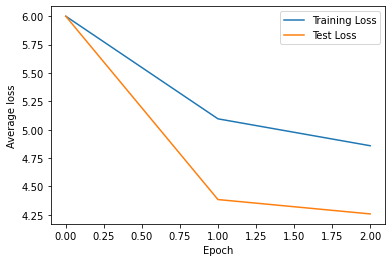

-------------------------------------------------------------------------------
Epoch starting at: 17:09:48


In [42]:
num_epochs = 5
current = 0

criterion = torch.nn.CrossEntropyLoss()

full_results = []

learning_rates = [1e-2, 1e-3, 1e-4][1:2]
num_layers_values = [1, 5, 10][:1]
hidden_sizes = [500, 1000, 1500, 2500][1:2]
dropout_probs = [0, 0.25, 0.5][:1]

skill_embedding_size=100
certs_embedding_size=50
license_embedding_size=10
language_embedding_size=15
address_embedding_size=25
function_embedding_size=250
isco4_embedding_size=150
education_embedding_size=10
isco_level_embedding_size=10
company_embedding_size=300
w2v_embedding_size = 300

try:            
    for learning_rate in learning_rates:
        for num_layers in num_layers_values:
            for hidden_size in hidden_sizes:
                for dropout_prob in dropout_probs:

                    lstm = HCPNN(num_classes=num_classes,
                                 input_size=num_features,
                                 num_layers=num_layers,
                                 hidden_size=hidden_size,
                                 dropout_prob=dropout_prob,
                                 skills=skills, 
                                 certs=certs,
                                 licenses=licenses,
                                 languages=languages,
                                 addresses=addresses,
                                 w2v=w2v,
                                 skill_embedding_size=skill_embedding_size,
                                 certs_embedding_size=certs_embedding_size,
                                 license_embedding_size=license_embedding_size,
                                 language_embedding_size=language_embedding_size,
                                 address_embedding_size=address_embedding_size,
                                 function_embedding_size=function_embedding_size,
                                 isco4_embedding_size=isco4_embedding_size,
                                 education_embedding_size=education_embedding_size,
                                 isco_level_embedding_size=isco_level_embedding_size,
                                 company_embedding_size=company_embedding_size,
                                 candidate_lengths=candidate_lens,
                                 max_len=max_len)

                    lstm = lstm.to(device)

                    optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
                    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

                    if current >= 1:
                        print("\n\n\n")

                    print(f"Current iteration {current}/{len(learning_rates) * len(num_layers_values) * len(hidden_sizes) * len(dropout_probs)}")
                    print(f"- Initial learning rate: {learning_rate}\n- Model: \n\n", lstm, "\n")

                    trainloader, valloader = create_loaders(to_fill, idxs, y, split_size=0.8, 
                                                            weight_type=3, batch_size=512)

                    # Store results of current configuration
                    outcome = train_loop(lstm, trainloader, valloader, optimizer, scheduler, criterion, num_epochs)
                    outcome["lr"] = [learning_rate] * num_epochs
                    outcome["Number of layers"] = [num_layers] * num_epochs
                    outcome["Nodes per layer"] = [hidden_size] * num_epochs
                    outcome["Dropout"] = [dropout_prob] * num_epochs

                    full_results.append(outcome)

                    with open("../results/LSTM.json", "w") as current_stats:
                        json.dump(full_results, current_stats)

                    current += 1
                    
except KeyboardInterrupt:
    pass

In [43]:
merge_results = defaultdict(list)

for res in full_results:
    for k, v in res.items():
        merge_results[k].extend(v)
        
total = pd.DataFrame(merge_results).set_index(["lr", "Number of layers", "Nodes per layer", "Dropout", "Epoch"])

In [46]:
total.sort_values(by="Acc@1", ascending=False).head(10)

Acc@1     Acc@5  \
lr    Number of layers Nodes per layer Dropout Epoch                       
0.001 1                1000            0.0     3      0.206331  0.502220   
                       1500            0.0     2      0.204485  0.501429   
                       1000            0.0     1      0.201627  0.499275   
                       1500            0.0     3      0.201275  0.496681   
                       2500            0.0     4      0.200132  0.497164   
                                               5      0.199516  0.495406   
                       500             0.0     4      0.198681  0.501693   
                       1000            0.0     5      0.197890  0.487228   
                       1500            0.0     4      0.197802  0.489075   
                       1000            0.0     4      0.197538  0.494922   

                                                        Acc@10    Acc@20  \
lr    Number of layers Nodes per layer Dropout Epoch                       
0.001 1                1000            0.0     3      0.641899  0.770279   
                       1500            0.0     2      0.639657  0.766190   
                       1000            0.0     1      0.634293  0.755023   
                       1500            0.0     3      0.637239  0.767333   
                       2500            0.0     4      0.642954  0.769532   
                                               5      0.637371  0.768608   
                       500             0.0     4      0.636448  0.765091   
                       1000            0.0     5      0.630600  0.764432   
                       1500            0.0     4      0.630820  0.764476   
                       1000            0.0     4      0.633502  0.766410   

                                                      test_loss  \
lr    Number of layers Nodes per layer Dropout Epoch              
0.001 1                1000            0.0     3       3.589761   
                       1500            0.0     2       3.597320   
                       1000            0.0     1       3.752362   
                       1500            0.0     3       3.636479   
                       2500            0.0     4       3.714275   
                                               5       3.817389   
                       500             0.0     4       3.631455   
                       1000            0.0     5       3.736513   
                       1500            0.0     4       3.693342   
                       1000            0.0     4       3.656663   

                                                      training_loss  duration  
lr    Number of layers Nodes per layer Dropout Epoch                           
0.001 1                1000            0.0     3           2.663452       111  
                       1500            0.0     2           3.224946       164  
                       1000            0.0     1           4.532464       111  
                       1500            0.0     3           2.428572       165  
                       2500            0.0     4           1.653296       309  
                                               5           1.261245       307  
                       500             0.0     4           2.643039        77  
                       1000            0.0     5           1.699791       111  
                       1500            0.0     4           1.884410       164  
                       1000            0.0     4           2.105742       110

In [45]:
# total.to_csv("../results/LSTM-results_x.csv")

In [73]:
tested_results = pd.read_csv("../results/LSTM-results.csv").set_index(["lr", "Number of layers", "Nodes per layer", "Dropout", "Epoch"])
tested_results.sort_values(by="Acc@1", ascending=False).head(10)

Acc@1     Acc@5  \
lr    Number of layers Nodes per layer Dropout Epoch                       
0.001 1                1000            0.25    2      0.198109  0.466828   
                       500             0.00    3      0.197494  0.475357   
                                       0.25    2      0.196966  0.475313   
                       1500            0.25    2      0.195164  0.466124   
                       1000            0.00    2      0.192394  0.474390   
                                       0.50    3      0.191515  0.461728   
                                       0.00    3      0.191515  0.468235   
                       500             0.25    3      0.191031  0.461200   
                       1500            0.00    2      0.190943  0.462475   
                                       0.25    3      0.190767  0.459178   

                                                        Acc@10    Acc@20  \
lr    Number of layers Nodes per layer Dropout Epoch                       
0.001 1                1000            0.25    2      0.602198  0.727808   
                       500             0.00    3      0.609409  0.738932   
                                       0.25    2      0.597978  0.725038   
                       1500            0.25    2      0.594109  0.723719   
                       1000            0.00    2      0.607386  0.729523   
                                       0.50    3      0.596219  0.727325   
                                       0.00    3      0.604485  0.737657   
                       500             0.25    3      0.595603  0.723939   
                       1500            0.00    2      0.598417  0.735107   
                                       0.25    3      0.591647  0.732073   

                                                      test_loss  \
lr    Number of layers Nodes per layer Dropout Epoch              
0.001 1                1000            0.25    2       3.654136   
                       500             0.00    3       3.616603   
                                       0.25    2       3.702973   
                       1500            0.25    2       3.667516   
                       1000            0.00    2       3.652411   
                                       0.50    3       3.707977   
                                       0.00    3       3.652158   
                       500             0.25    3       3.679106   
                       1500            0.00    2       3.669754   
                                       0.25    3       3.679190   

                                                      training_loss  duration  
lr    Number of layers Nodes per layer Dropout Epoch                           
0.001 1                1000            0.25    2           3.856898       122  
                       500             0.00    3           3.149045        87  
                                       0.25    2           4.052021        87  
                       1500            0.25    2           3.616276       170  
                       1000            0.00    2           3.582638       121  
                                       0.50    3           3.511576       121  
                                       0.00    3           2.721269       121  
                       500             0.25    3           3.454050        85  
                       1500            0.00    2           3.363616       171  
                                       0.25    3           2.887053       171

In [74]:
optimal_settings = tested_results.sort_values(by="Acc@1", ascending=False).head(1)
settings_dict = dict(zip(list(optimal_settings.index.names), list(optimal_settings.index[0])))
settings_dict

{'lr': 0.001,
 'Number of layers': 1,
 'Nodes per layer': 1000,
 'Dropout': 0.25,
 'Epoch': 2}

In [76]:
num_epochs=25
criterion = torch.nn.CrossEntropyLoss()

lstm = HCPNN(num_classes=num_classes,
             input_size=num_features,
             num_layers=int(settings_dict["Number of layers"]),
             hidden_size=int(settings_dict["Nodes per layer"]),
             dropout_prob=settings_dict["Dropout"],
             skills=skills, 
             certs=certs,
             licenses=licenses,
             languages=languages,
             addresses=addresses,
             w2v=w2v,
             address_embedding_size=25,
             candidate_lengths=candidate_lens,
             max_len=max_len)

lstm = lstm.to(device)

optimizer = torch.optim.Adam(lstm.parameters(), lr=settings_dict["lr"])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)

print(f"Training optimal model.")

trainloader, valloader = create_loaders(to_fill, idxs, y, split_size=0.8, 
                                        weight_type=3, batch_size=512)

# Store results of current configuration
outcome = train_loop(lstm, trainloader, valloader, optimizer, scheduler, criterion, num_epochs)

Training optimal model.
-------------------------------------------------------------------------------
Epoch starting at: 09:15:35


KeyboardInterrupt: 

In [69]:
switches = defaultdict(lambda: defaultdict(int))

for c, jobs in career_paths.iteritems():
    jobs = jobs[:,-1]
    for i in range(len(jobs)):
        if i < len(jobs) - 1 and jobs[i] != jobs[i + 1]:
            switches[jobs[i]][jobs[i  + 1]] += 1
            
most_common = {k: nlargest(1, v, key=v.get)[0] for k, v in switches.items()}

Batch accuracy: 0.19140625

Previous-job baseline accuracy: 0.0
Majority class accuracy: 0.107421875

Fraction of previous job predictions: 0.01953125
Majority class predictions: 0.087890625
Majority switch predictions: 0.0


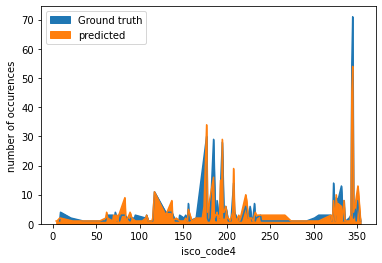

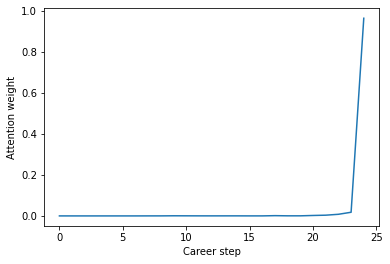

In [72]:
with torch.no_grad():
    for candidate, career, job in valloader:
        career, job = career.to(device), job.to(device)
        pred, weight = lstm(candidate, career)
        
        print("Batch accuracy:", (pred.argmax(1) == job).type(torch.float).mean().item())        
        print()
        
        # Check how often the model predicted the previous job + compare to baseline performance
        previous_job = torch.Tensor(career_paths.loc[candidate.cpu()].apply(lambda x: x[-2][-1]).values).to(device)
        print("Previous-job baseline accuracy:", (job == previous_job).cpu().numpy().mean())
        print("Majority class accuracy:", (job == majority_class).cpu().numpy().mean())
        print()
        
        print("Fraction of previous job predictions:", (pred.argmax(1) == previous_job).cpu().numpy().mean())
        print("Majority class predictions:", (pred.argmax(1) == majority_class).cpu().numpy().mean())
        print("Majority switch predictions:", np.mean([i.item() == most_common[i.item()] for i in pred.argmax(1).cpu().numpy()]))
                                                
        a = pd.Series(Counter(job.tolist()))
        a.sort_index().plot(kind="area", label="Ground truth")
            
        b = pd.Series(Counter(pred.argmax(1).tolist()))
        b.sort_index().plot(kind="area", label="predicted")
                
        plt.xlabel("isco_code4")
        plt.ylabel("number of occurences")
        plt.legend()
        
        plt.show()
        a = weight.cpu().detach().numpy().mean(axis=0)            
        plt.plot(a, label="average")
        # plt.plot(weights[0][np.random.choice(range(len(weights[0])))].cpu().detach().numpy(), label="random example")
        plt.xlabel("Career step")
        plt.ylabel("Attention weight")
        plt.show()
        
        break

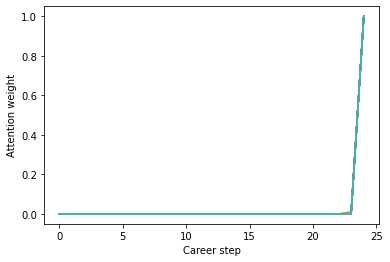

In [71]:
b = weight.cpu().detach().numpy()

for _ in range(20):
    c = np.random.randint(0, len(b))
    plt.plot(b[c])
    plt.xlabel("Career step")
    plt.ylabel("Attention weight")